In [1]:
import pandas as pd

# === 1. Carregar ===
pairs_df = pd.read_csv("pairs_df.csv")
compounds_df = pd.read_csv("compounds.csv")

# === 2. Normalizar nomes das colunas ===
pairs_df.columns = pairs_df.columns.str.strip().str.lower()
compounds_df.columns = compounds_df.columns.str.strip().str.lower()

# === 3. Identificar colunas de ID e SMILES ===
mol_id_col = "id" if "id" in compounds_df.columns else compounds_df.columns[0]
smiles_col = "smiles" if "smiles" in compounds_df.columns else compounds_df.columns[1]

# === 4. Add smiles ===
merged = pairs_df.merge(compounds_df[[mol_id_col, smiles_col]], left_on="mol1", right_on=mol_id_col)
merged = merged.merge(compounds_df[[mol_id_col, smiles_col]], left_on="mol2", right_on=mol_id_col, suffixes=("_mol1", "_mol2"))

# ✅ FILTRAR separation != -1
merged = merged[merged["separation"] != -1]

# === 5. Manter e ordenar pela coluna separation ===
merged = merged[["mol1", "smiles_mol1", "mol2", "smiles_mol2", "separation"]]
merged = merged.sort_values(by="separation").reset_index(drop=True)

# === 6. Exportar ===
merged.to_csv("merged_pairs_with_smiles.csv", index=False)

print("✅ Dataset criado: 'merged_pairs_with_smiles.csv'")



✅ Dataset criado: 'merged_pairs_with_smiles.csv'


In [2]:
from rdkit.Chem import MolFromSmiles
from deepmol.compound_featurization import NPClassifierFP

fp = NPClassifierFP()
mol = MolFromSmiles("CCO")  # etanol, por exemplo
vector = fp._featurize(mol)

print(len(vector))  # este é o max_distance


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
/home/jcapela/.local/share/mamba/envs/np_benchmark/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-24 18:21:03.818403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-24 18:21:03.818461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-24 18:21:03.819862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been re

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2025-07-24 18:21:04.684429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
/home/jcapela/.local/share/mamba/envs/np_benchmark/lib/python3.10/site-packages/deepmol/compound_featurization/__init__.py:20: UserWarning: Mol2Vec not available. Please install it to use it. (pip install git+https://github.com/samoturk/mol2vec#egg=mol2vec)
  warnings.warn("Mol2Vec not available. Please install it to use it. "


6144


Ciclo for para ir buscar os 2 smiles ao dataset:

In [29]:
import pandas as pd
import numpy as np
from rdkit.Chem import MolFromSmiles
from deepmol.compound_featurization import NPClassifierFP, BiosynfoniKeys, NeuralNPFP, MHFP, MorganFingerprint
from deepmol.compound_featurization import LLM
from tqdm import tqdm
from transformers import BertConfig, BertModel, ModernBertModel, ModernBertConfig 
from deepmol.tokenizers import NPBERTTokenizer
import os



# === 1. Carregar o dataset ===
df = pd.read_csv("merged_pairs_with_smiles.csv")

# === 2. Lista de featurizadores ===
featurizers = {
    "NPClassifierFP": NPClassifierFP(),
    "Biosynfoni": BiosynfoniKeys(),
    "NP_AUX": NeuralNPFP(),
    "MHFP": MHFP(),
    "MorganFP": MorganFingerprint(),
    "NPBERT": LLM(model_path="../NPBERT", model=BertModel, config_class=BertConfig,
                          tokenizer=NPBERTTokenizer(vocab_file=os.path.join("../NPBERT", "vocab.txt")), device="cuda:1"),
    "ModernBERT": LLM(model_path="../ModernBERT", model=ModernBertModel, config_class=ModernBertConfig, device="cuda:1")
}

# === 3. Função de similaridade do cosseno ===
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    if norm_product == 0:
        return 0
    return dot_product / norm_product

# === 4. Aplicar para cada featurizador ===
for name, featurizer in featurizers.items():
    print(f"🔄 A calcular similaridade com: {name}")
    similarities = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Calculando similaridades para {name}"):
        smile1 = row["smiles_mol1"]
        smile2 = row["smiles_mol2"]

        if name in ["NPClassifierFP", "Biosynfoni", "NP_AUX", "MHFP", "MorganFP"]:
            mol1 = MolFromSmiles(smile1)
            mol2 = MolFromSmiles(smile2)

            if mol1 and mol2:
                try:
                    fp1 = featurizer._featurize(mol1)
                    fp2 = featurizer._featurize(mol2)
                    sim = cosine_similarity(fp1, fp2)
                except Exception as e:
                    sim = 0
            else:
                sim = 0

        else:
            try:
                fp1 = featurizer._featurize(smile1)
                fp2 = featurizer._featurize(smile2)
                sim = cosine_similarity(fp1, fp2)
            except Exception as e:
                sim = 0

        similarities.append(sim)

    df[name] = similarities

# === 5. Guardar resultado final ===
df.to_csv("merged_pairs_with_all_fps_cosine.csv", index=False)
print("✅ Todas as similaridades foram calculadas com sucesso.")


Some weights of BertModel were not initialized from the model checkpoint at ../NPBERT/model.pt and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔄 A calcular similaridade com: NPClassifierFP


Calculando similaridades para NPClassifierFP: 100%|██████████| 3697/3697 [00:07<00:00, 476.68it/s]


🔄 A calcular similaridade com: Biosynfoni


Calculando similaridades para Biosynfoni: 100%|██████████| 3697/3697 [00:06<00:00, 563.85it/s]


🔄 A calcular similaridade com: NP_AUX


Calculando similaridades para NP_AUX: 100%|██████████| 3697/3697 [00:23<00:00, 154.56it/s]


🔄 A calcular similaridade com: MHFP


Calculando similaridades para MHFP:   0%|          | 8/3697 [00:00<00:57, 64.34it/s]/home/jcapela/.local/share/mamba/envs/np_benchmark/lib/python3.10/site-packages/deepmol/compound_featurization/_mhfp.py:305: UserWarning: The length of the shingling is 0, which results in an empty set and an all zero folded fingerprint.
  warnings.warn(
Calculando similaridades para MHFP: 100%|██████████| 3697/3697 [00:54<00:00, 67.73it/s] 


🔄 A calcular similaridade com: MorganFP


Calculando similaridades para MorganFP: 100%|██████████| 3697/3697 [00:07<00:00, 474.91it/s]


🔄 A calcular similaridade com: NPBERT


Calculando similaridades para NPBERT: 100%|██████████| 3697/3697 [00:43<00:00, 84.66it/s]


🔄 A calcular similaridade com: ModernBERT


Calculando similaridades para ModernBERT: 100%|██████████| 3697/3697 [04:34<00:00, 13.46it/s]


✅ Todas as similaridades foram calculadas com sucesso.


Dar clean ao dataset
remove proton, water e o top 1% de frequencia

In [30]:
import pandas as pd

# === 1. Carregar o dataset ===
df = pd.read_csv("merged_pairs_with_all_fps_cosine.csv")

# === 2. Remover WATER e PROTON ===
df = df[~df["mol1"].isin(["WATER", "PROTON"]) & ~df["mol2"].isin(["WATER", "PROTON"])]

# === 3. Contar frequência total de cada molécula ===
mol_counts = pd.concat([df["mol1"], df["mol2"]]).value_counts()

# === 4. Determinar moléculas muito repetidas (top 1%) ===
threshold = mol_counts.quantile(0.99)
frequent_mols = mol_counts[mol_counts > threshold].index

# === 5. Remover pares com moléculas muito frequentes ===
df = df[~df["mol1"].isin(frequent_mols) & ~df["mol2"].isin(frequent_mols)]

# === 6. Guardar dataset filtrado ===
df.to_csv("filtered_pairs_removed_water_proton_repetidos.csv", index=False)

print("✅ Ficheiro salvo como 'filtered_pairs_removed_water_proton_repetidos.csv'")


✅ Ficheiro salvo como 'filtered_pairs_removed_water_proton_repetidos.csv'


Gráfico

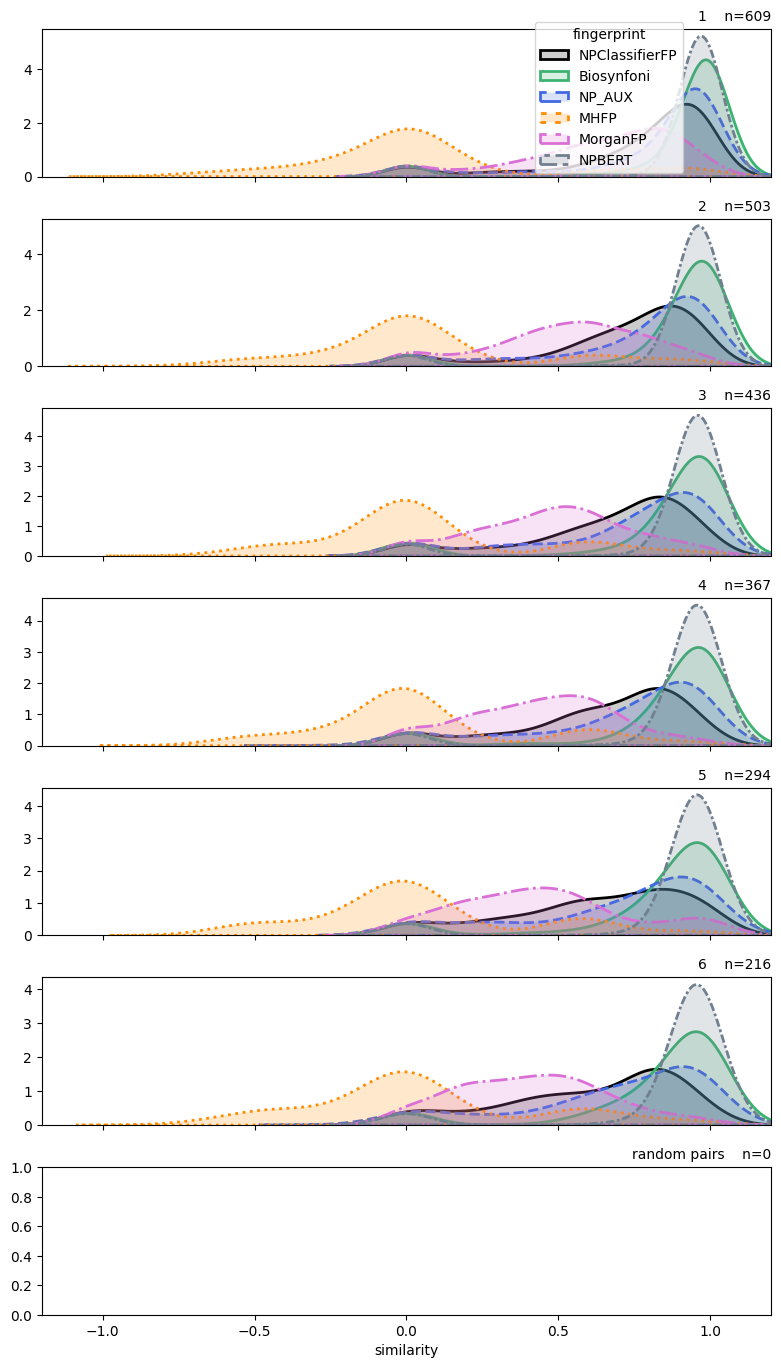

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Carregar o dataset ===
df = pd.read_csv("filtered_pairs_removed_water_proton_repetidos.csv")

# === 2. Definir fingerprints a usar (que foram realmente geradas) ===
fps_all = ["NPClassifierFP", "Biosynfoni", "NP_AUX", "MHFP", "MorganFP", "NPBERT"]
fps = [fp for fp in fps_all if fp in df.columns]

colors = {
    "NPClassifierFP": "black",
    "Biosynfoni": "mediumseagreen",
    "NP_AUX": "royalblue",
    "MHFP": "darkorange",
    "MorganFP": "orchid",
    "NPBERT": "slategray",
    # "ModernBERT": "darkviolet"
}
linestyles = {
    "NPClassifierFP": "-",
    "Biosynfoni": "-",
    "NP_AUX": "--",
    "MHFP": ":",
    "MorganFP": "-.",
    "NPBERT": (0, (3, 1, 1, 1)),  # estilo pontilhado alternado,
    # "ModernBERT": (0, (1, 1))  # estilo pontilhado simples
}

# === 3. Converter colunas para numérico, ignorando erros ===
for fp in fps:
    df[fp] = pd.to_numeric(df[fp], errors="coerce")

# === 4. Criar gráfico por separation ===
fig, axes = plt.subplots(7, 1, figsize=(8, 14), sharex=True)

for i, sep in enumerate([1, 2, 3, 4, 5, 6, -1]):
    ax = axes[i]
    subset = df[df["separation"] == sep]
    label = f"{sep}" if sep != -1 else "random pairs"

    for fp in fps:
        if fp in subset.columns:
            sns.kdeplot(
                data=subset[fp].dropna(),
                ax=ax,
                label=fp if i == 0 else None,
                linewidth=2,
                linestyle=linestyles[fp],
                color=colors[fp],
                fill=True,
                alpha=0.2
            )

    ax.set_title(f"{label}    n={len(subset)}", loc='right', fontsize=10)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylabel("")
    if i < 6:
        ax.set_xlabel("")

axes[-1].set_xlabel("similarity")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="fingerprint", loc="upper right", bbox_to_anchor=(0.88, 0.97))
plt.tight_layout()
plt.subplots_adjust(top=0.96)

# === 5. Guardar e mostrar ===
plt.savefig("fingerprint_similarity_distributions.png", dpi=300)
plt.show()
